# **Homework 3: Neural Language Models and Hugging Face**

This homework covers RNN language models and gets you to try out Hugging Face for yourselves.

Also, before starting, please change your Colab runtime to the GPU backend by going to **Runtime > Change runtime type > Hardware accelerator > T4 GPU**.

# **Q1.** RNN Language Model (50 points)
In this question, we use PyTorch to implement an RNN language model. First, you'll do so without the attention mechanism. Then we'll also add attention.

We first need to preprocess the data and create minibatches, which has already been implemented in the cells below before Q1.1. Remember from the PyTorch intro session that minibatches provide a trade-off between meaningful gradient updates and computational efficiency.

For the language modeling tasks, the input batches are $N\times L$ matrices and outputs are $N\times L \times V$ where $N$ is the batch size, and $L$ is the maximum sequence length and $V$ is the size of the vocabulary. Sequences shorter than $L$ will be padded, and sequences longer than $L$ get truncated. The output then is a distribution over the vocabulary for each step in the sequence (hence size $V$ at the last dimension of the output), which is the prediction received from the model.

Run the cells below to prepare the data.

In [1]:
import torch, os, sys, random, time
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn, optim
from collections import *
import numpy as np
from tqdm.notebook import tqdm
from time import time

print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)

if device == torch.device("cpu"):
  print("BEFORE YOU CONTINUE, change your Colab runtime to the GPU backend by going to Runtime > Change runtime type > Hardware accelerator > T4 GPU")

2.2.1+cu121
device:  cuda:0


In [2]:
import requests

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
response.raise_for_status() # Raise an exception for invalid HTTP status codes
text_data = response.text

text_data = text_data.replace(',', ' , ').replace('.', ' . ').replace('?', ' ? ').replace('!', ' ! ').replace(':', ' : ')
text_data = text_data.replace('\n\n', ' </s> <s> ')
text_data = text_data.replace('\n', ' ')
text_data = text_data.replace('  ', ' ')
text_data = '<s> ' + text_data + '</s>'
print(text_data[:200])
print()
print(text_data[-200:])

<s> First Citizen : Before we proceed any further , hear me speak . </s> <s> All : Speak , speak . </s> <s> First Citizen : You are all resolved rather to die than to famish ? </s> <s> All : Resolved 

eep With eyes wide open; standing , speaking , moving , And yet so fast asleep . </s> <s> ANTONIO : Noble Sebastian , Thou let'st thy fortune sleep--die , rather; wink'st Whiles thou art waking . </s>


In [3]:
vocab2id = {
    '<PAD>': 0,
    '<UNK>': 1,
    '<s>': 2,
    '</s>': 3
}
vocab2count = Counter(text_data.split())
next_v_id = 4

for v in vocab2count:
  if vocab2count[v] < 3:  # anything occuring less than 3 times will be replaced by <UNK>
    continue

  elif v not in vocab2id:  # <s> and </s> already in vocab2id
    vocab2id[v] = next_v_id
    next_v_id += 1

id2vocab = {v: k for k, v in vocab2id.items()}

In [4]:
sentences = text_data.split(' </s> ')
print(len(sentences))

def pad_to_max_len(sentences, max_len = 40):
  list_of_encoded_sentences = []

  for sentence in sentences:
    tokenized_sentence = sentence.split()

    if tokenized_sentence[-1] != '</s>':
      tokenized_sentence.append('</s>')

    if len(tokenized_sentence) >= max_len:  # we may have to truncate
      tokenized_sentence = tokenized_sentence[:max_len - 1] + ['</s>']  # truncate and add eos

    encoded_sentence = [vocab2id.get(t, vocab2id['<UNK>']) for t in tokenized_sentence]

    while len(encoded_sentence) < max_len:
      encoded_sentence.append(0)  # append with <PAD>

    list_of_encoded_sentences.append(encoded_sentence)

  return torch.LongTensor(list_of_encoded_sentences)

padded_and_encoded_data = pad_to_max_len(sentences)
print(padded_and_encoded_data.shape)

7222
torch.Size([7222, 40])


In [5]:
shuffled_indices = torch.randperm(padded_and_encoded_data.shape[0])
train_size, dev_size, test_size = 6000, 600, 622

dataset_splits = {
    'train': padded_and_encoded_data.index_select(0, shuffled_indices[:train_size]).to(device),
    'dev': padded_and_encoded_data.index_select(0, shuffled_indices[train_size:train_size + dev_size]).to(device),
    'test': padded_and_encoded_data.index_select(0, shuffled_indices[train_size + dev_size:]).to(device),
}

print(f"train split tensor shape: {dataset_splits['train'].shape}")
print(f"dev split tensor shape: {dataset_splits['dev'].shape}")
print(f"test split tensor shape: {dataset_splits['test'].shape}")

train split tensor shape: torch.Size([6000, 40])
dev split tensor shape: torch.Size([600, 40])
test split tensor shape: torch.Size([622, 40])


## ***Q1.1*** Below, we use the available modules in PyTorch to create a full RNN language model. First, look at the [documentation](https://pytorch.org/docs/stable/index.html) for each module (i.e, [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html), [nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) and then implement the forward function. (25 points)

In [6]:
class RNNLM(nn.Module):
    def __init__(self, params):
        super(RNNLM, self).__init__()
        self.vocab_size = params['vocab_size']
        self.d_emb = params['d_emb']
        self.d_hid = params['d_hid']
        self.n_layer = 1
        self.batch_size = params['batch_size']
        self.encoder = nn.Embedding(self.vocab_size, self.d_emb)
        self.rnn = nn.RNN(self.d_emb, self.d_hid, self.n_layer, batch_first = True)
        self.decoder = nn.Linear(self.d_hid, self.vocab_size)

    def forward(self, batch):
        batch_size, seq_len = batch.shape
        hidden = (torch.zeros(self.n_layer, batch_size, self.d_hid).to(device)) # initial hidden state set to zeros
        embeddings = self.encoder(batch)
        out, hidden = self.rnn(embeddings, hidden)
        output = self.decoder(out)
        return output

        """
            IMPLEMENT HERE
            Encode the data using the embedding layer you initialized.
            Pass the encoded data and hidden states to your RNN.
            Return UNNORMALIZED logits for each token's prediction.
        """

Before moving on, let's do a quick sanity check of your implementation.

In [7]:
# DO NOT CHANGE
def test_RNNLM():
    test_batch = torch.LongTensor(5, 4).random_(0, 10).to(device)
    params = {}
    params['vocab_size'] = len(id2vocab)
    params['d_emb'] = 8
    params['d_hid'] = 8
    params['batch_size'] = 5
    testnet = RNNLM(params)
    testnet.to(device)
    test_output = testnet(test_batch)

    assert test_output.shape[0] == params['batch_size'], "size of dimension 0 is incorrect, expect %i but got %i" % \
                                                          (params['batch_size'], test_output.shape[0])
    assert test_output.shape[1] == test_batch.shape[1], "size of dimension 1 is incorrect, expect %i but got %i" % \
                                                          (test_batch.shape[1], test_output.shape[1])
    assert test_output.shape[2] == params['vocab_size'], "size of dimension 2 is incorrect, expect %i but got %i" % \
                                                          (params['vocab_size'], test_output.shape[2])
    print("All good to go!")

test_RNNLM()

All good to go!


We can now train and test our model. The functions for training and evaluation have been provided to you. Read through it and comprehend it. Then answer the following guestions in a few sentences.

### ***Q1.1.1*** In `train_lm`, what is `criterion = nn.CrossEntropyLoss(ignore_index=0)` for? Specifically, what does `ignore_index` do, and why is it set to zero?

**YOUR ANSWER HERE**

The "criterion = nn.CrossEntropyLoss(ignore_index = 0) is the loss or the cost function used while training the model. The ignore_index is set to 0 so that the loss function omits the very first token while calculating the loss. Since, the model uses padding to fill up senetences with less number of tokens. These padded tokens are not required while computing the cross-entropy loss. If the ignore_index was not set to zero, then the model would unnecessarily get penalized for "falsely" predicting a padded token. Therefore, it will result in a low accuracy.

### ***Q1.1.2*** In `train_lm`, what is `net.eval()` for? How is it beneficial to include it?

**YOUR ANSWER HERE**

net.eval() function puts the model in evaluation mode. During the evaluation mode (using net.eval()), batch normalization is performed and neuron dropout is disabled. It is beneficial to include net.eval() as it enusures consistent model evaluation as no randomness is introduced. Gradients are still calculated during the evalauation phase when net.eval() is used, this makes sure that the model performs weel and does not overfit.     

In [8]:
# perplexity evaluation
# DO NOT CHANGE
def compute_perplexity(dataset, net, vocab_size, bsz = 64, pad_index = 0):
    criterion = nn.CrossEntropyLoss(ignore_index = pad_index, reduction = 'sum')
    num_examples, seq_len = dataset.size()
    batches = [(start, start + bsz) for start in\
               range(0, num_examples, bsz)]
    total_unmasked_tokens = 0. # count how many unpadded tokens there are
    nll = 0.

    for b_idx, (start, end) in tqdm(enumerate(batches), total=len(batches)):
        batch = dataset[start:end]
        ut = (batch!=pad_index).sum()

        try:
          preds = net(batch).logits

        except:
          preds = net(batch)

        targets = batch[:, 1:].contiguous().view(-1)
        preds = preds[:, :-1, :].contiguous().view(-1, vocab_size)
        loss = criterion(preds, targets)
        nll += loss.detach()
        total_unmasked_tokens += ut

    perplexity = torch.exp(nll / total_unmasked_tokens).cpu()
    return perplexity.data

# training and validation
# DO NOT CHANGE
def train_lm(dataset, params, net):
    criterion = nn.CrossEntropyLoss(ignore_index = 0)
    optimizer = optim.Adam(net.parameters(), lr = params['learning_rate'])
    num_examples, seq_len = dataset.size()
    batches = [(start, start + params['batch_size']) for start in\
               range(0, num_examples, params['batch_size'])]

    for epoch in tqdm(range(params['epochs']), total = params['epochs']):
        ep_loss = 0.
        start_time = time()
        random.shuffle(batches)
        net.train()
        # for each batch, calculate loss and optimize model parameters

        for b_idx, (start, end) in enumerate(batches):
            batch = dataset[start:end]
            preds = net(batch)
            preds = preds[:, :-1, :].contiguous().view(-1, net.vocab_size)
            targets = batch[:, 1:].contiguous().view(-1)
            loss = criterion(preds, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()
            ep_loss += loss

        net.eval()
        print('epoch: %d, loss: %0.2f, time: %0.2f sec, dev perplexity: %0.2f' %\
              (epoch, ep_loss, time()-start_time, compute_perplexity(dataset_splits['dev'], net, net.vocab_size)))

Now we use these functions to train and test the model. Under correct implementation, we expect perplexity of 85-95 after 5 epochs.

In [9]:
# DO NOT CHANGE
params = {}
params['vocab_size'] = len(id2vocab)
params['d_emb'] = 512
params['d_hid'] = 256
params['batch_size'] = 64
params['epochs'] = 5
params['learning_rate'] = 0.001

RNNnet = RNNLM(params)
RNNnet.to(device)
train_lm(dataset_splits['train'], params, RNNnet)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 541.62, time: 2.39 sec, dev perplexity: 130.91


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1, loss: 462.49, time: 1.41 sec, dev perplexity: 105.08


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 2, loss: 439.05, time: 1.45 sec, dev perplexity: 94.60


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 3, loss: 421.73, time: 1.27 sec, dev perplexity: 89.58


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 4, loss: 407.59, time: 1.26 sec, dev perplexity: 86.13


In [10]:
RNNnet.eval()
print('%s perplexity: %0.2f' % ('test', compute_perplexity(dataset_splits['test'], RNNnet, RNNnet.vocab_size)))

  0%|          | 0/10 [00:00<?, ?it/s]

test perplexity: 89.80


## ***Q1.2*** Now let's pay some attention! (25 points)

In this part we extend the RNN implementation from before to use attention. Read the notes and complete the forward functions in each of the classes below.

In [11]:
class ATTNLM(nn.Module):
    def __init__(self, params):
        super(ATTNLM, self).__init__()
        self.vocab_size = params['vocab_size']
        self.d_emb = params['d_emb']
        self.d_hid = params['d_hid']
        self.n_layer = 1
        self.btz = params['batch_size']
        self.encoder = nn.Embedding(self.vocab_size, self.d_emb)
        self.attn = Attention(self.d_hid)
        self.rnn = nn.RNN(self.d_emb, self.d_hid, self.n_layer, batch_first = True)
        # the combined_W maps to map combined hidden states and context vectors to d_hid
        self.combined_W = nn.Linear(self.d_hid * 2, self.d_hid)
        self.decoder = nn.Linear(self.d_hid, self.vocab_size)

    def forward(self, batch, return_attn_weights = False):
        batch_size, seq_len = batch.shape
        hidden = torch.zeros(self.n_layer, batch_size, self.d_hid).to(device)
        embeddings = self.encoder(batch)
        output, hidden = self.rnn(embeddings, hidden)
        context_vectors, weights_attention = self.attn(output)
        vectors = torch.cat([output, context_vectors], dim = 2)
        outputs = self.decoder(self.combined_W(vectors))

        if return_attn_weights:
            return weights_attention

        else:
            return outputs

        """
            IMPLEMENT HERE
            Copy your implementation of RNNLM, make sure it passes the RNNLM check
            In addition to that, you need to add the following 3 things
            1. pass rnn output to attention module, get context vectors and attention weights
            2. concatenate the context vec and rnn output, pass the combined
               vector to the layer dealing with the combined vectors (self.combined_W)
            3. if return_attn_weights, instead of returning the [N, L, V]
               matrix, return the attention weight matrix of dimension [N, L, L]
               which was received from the forward function of attnetion module
        """

class Attention(nn.Module):
    def __init__(self, d_hidden):
        super(Attention, self).__init__()
        self.d_hid = d_hidden

    def forward(self, x):
        batch_seq_len = x.shape[1]
        batch_size, seq_len, _ = x.size()
        attn_scores = torch.zeros((batch_size, batch_seq_len, batch_seq_len), device = x.device)
        context_vectors = torch.zeros(batch_size, batch_seq_len, self.d_hid, device = x.device)

        for t in range(batch_seq_len):

          if t > 0:
              scores = torch.bmm(x[:, t:t + 1, :], x[:, :t, :].transpose(1, 2))
              scores = F.softmax(scores, dim = -1)
              attn_scores[:, t, :t] = scores.squeeze(1)
              context_vector = torch.bmm(scores, x[:, :t, :]).squeeze(1)
              context_vectors[:, t, :] = context_vector

        return context_vectors, attn_scores

        """
            IMPLEMENT HERE
            For each time step t
                1. Obtain attention attn_scores for step 0 to (t-1)
                   This should be a dot product between current hidden state (x[:,t:t+1,:])
                   and all previous states x[:, :t, :]. While t=0, since there is not
                   previous context, the context vector and attention weights should be of zeros.
                   You might find torch.bmm useful for computing over the whole batch.
                2. Turn the attn_scores you get for 0 to (t-1) steps to a distribution.
                   You might find F.softmax to be helpful.
                3. Obtain the sum of hidden states weighted by the attention distribution
            Concat the context vector you get in step 3. to a matrix.

            Also remember to store the attention weights, the attention matrix for
            each training instance should be a lower triangular matrix. Specifically, in
            each row, element 0 to t-1 should sum to 1, the rest should be padded with 0.
            e.g.
            [ [0.0000, 0.0000, 0.0000, 0.0000],
              [1.0000, 0.0000, 0.0000, 0.0000],
              [0.4246, 0.5754, 0.0000, 0.0000],
              [0.2798, 0.3792, 0.3409, 0.0000] ]

            Return the context vector matrix and the attention weight matrix

        """

In [12]:
def test_ATTNLM():
    test_batch = torch.LongTensor(5, 4).random_(0, 10).to(device)
    params = {}
    params['vocab_size'] = len(id2vocab)
    params['d_emb'] = 8
    params['d_hid'] = 8
    params['batch_size'] = 5
    testnet = ATTNLM(params)
    testnet.to(device)
    test_output = testnet(test_batch)
    assert test_output.shape[0] == params['batch_size'], "size of dimension 0 is incorrect, expect %i but got %i" % \
                                                          (params['batch_size'], test_output.shape[0])
    assert test_output.shape[1] == test_batch.shape[1], "size of dimension 1 is incorrect, expect %i but got %i" % \
                                                          (test_batch.shape[1], test_output.shape[1])
    assert test_output.shape[2] == params['vocab_size'], "size of dimension 2 is incorrect, expect %i but got %i" % \
                                                          (params['vocab_size'], test_output.shape[2])
    testnet = ATTNLM(params)
    testnet.to(device)
    test_output = testnet(test_batch, return_attn_weights = True)
    assert test_output.shape[0] == params['batch_size'], "size of dimension 0 is incorrect, expect %i but got %i" % \
                                                          (params['batch_size'], test_output.shape[0])
    assert test_output.shape[1] == test_batch.shape[1], "size of dimension 1 is incorrect, expect %i but got %i" % \
                                                          (test_batch.shape[1], test_output.shape[1])
    assert test_output.shape[2] == test_batch.shape[1], "size of dimension 2 is incorrect, expect %i but got %i" % \
                                                          (test_batch.shape[1], test_output.shape[2])
    prob_dist = torch.sum(test_output, dim = 2)[:, 1:]
    assert all([x > 0.99 and x < 1.01 for x in prob_dist.reshape(-1)]), "attention weights not properly normalized, got {}".format(prob_dist)
    print("All good to go!")

test_ATTNLM()

All good to go!


Similar to before, we can train and test our model. Under correct implementation, we expect perplexity of 85-95 after 6 epochs.

In [13]:
# DO NOT CHANGE
params = {}
params['vocab_size'] = len(id2vocab)
params['d_emb'] = 512
params['d_hid'] = 256
params['n_layer'] = 1
params['batch_size'] = 64
params['epochs'] = 6
params['learning_rate'] = 0.0005
ATTNnet = ATTNLM(params)
ATTNnet.cuda()
train_lm(dataset_splits['train'], params, ATTNnet)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 561.48, time: 4.78 sec, dev perplexity: 150.60


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1, loss: 477.82, time: 5.05 sec, dev perplexity: 119.34


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 2, loss: 454.82, time: 5.24 sec, dev perplexity: 104.38


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 3, loss: 438.93, time: 3.15 sec, dev perplexity: 97.76


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 4, loss: 426.49, time: 2.98 sec, dev perplexity: 94.33


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 5, loss: 415.57, time: 2.99 sec, dev perplexity: 92.12


In [14]:
ATTNnet.eval()
print('%s perplexity: %0.2f' % ('test', compute_perplexity(dataset_splits['test'], ATTNnet, ATTNnet.vocab_size)))

  0%|          | 0/10 [00:00<?, ?it/s]

test perplexity: 95.51


Using the `sample_from_lm`, generate from both models by running the next two cells and answer the question below.

### ***Q1.2.1*** Describe distinctions, if any, between the outputs of two models. Explain your thoughts on why we don't observe more significant differences.

**YOUR ANSWER HERE**

The text generated (output) by the RNN with attention makes more sense as the words 'kinsman' and 'letters' appear to be in the same context. On the other hand, text generated by the RNN without attention lacks focus. The words which should be in the same context are not together, words like 'that' and 'this' appear repeatedly in a sentence. Overall, both outputs are not different by a large magnitude. It might be because of a small corpus (input dataset), or if the corpus has short sentences. In such a case, the implementation of attention would not be beneficial as the model would remember the context. Additionally, if the model is not trained on more epochs or if the model's hyperparameters are not finetuned, then attention would not be able to produce more meaningful output.  

In [15]:
def sample_from_lm(net, context, max_words = 50):
    with torch.no_grad():
        for i in range(max_words):
            data = torch.LongTensor([context]).to(device)
            decoded = net(data)
            decoded = decoded[0, -1].exp().cpu()
            w_i = torch.multinomial(decoded, 1)[0].item()

            if w_i in [1, 2, 3]:
                continue
            context.append(w_i)

        return context

context = [vocab2id[w] for w in '<s> First Citizen : '.split()]
rnn_completion = sample_from_lm(RNNnet, context)
print('rnn completion: ', ' '.join([id2vocab[w] for w in rnn_completion]))

rnn completion:  <s> First Citizen : What is't ! speak Clarence ! He shall the public but that name I not believe him in like to her . Did pray thee to lose , for thy matter to death the wine of Hereford , To did; the light That hence


In [16]:
context = [vocab2id[w] for w in '<s> First Citizen : '.split()]
rnn_completion = sample_from_lm(ATTNnet, context)
print('attention rnn completion: ', ' '.join([id2vocab[w] for w in rnn_completion]))

attention rnn completion:  <s> First Citizen : And , my son is . 3 KING HENRY VI , and my daily called ! Thou , were I know to the gaol of my Boatswain shall bear it . But in your liars ?


Now run the next cell to visualize attention weights.

### ***Q1.2.2*** Describe what the heat map is showing. Looking at this visualization, would you add any new hypothesis on why we don't see more strong differences between the two models?

**YOUR ANSWER HERE**

The bright yellow squares along the diagonal of the heatmap illustartes that the model predominantly focuses on the immediate preceding words in the context while predicting the next word. Further, the heatmap indicates the model does not (remember) pay attention to the context words that are far from the predicted word. This again shows that the corpus is either made up of short sentences or the corpus is small. Also, the hyperparameters might not be finetuned for this task.   

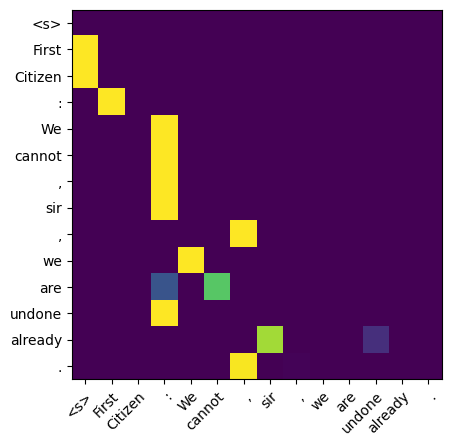

In [17]:
def plot_attn_heatmap(sent):
    sent_in_id = [vocab2id[w] for w in sent.split()]

    with torch.no_grad():
        data = torch.LongTensor([sent_in_id]).to(device)
        weights = ATTNnet(data, return_attn_weights = True)

    fig, ax = plt.subplots()
    sent_sp = sent.split()
    ax.set_xticks(np.arange(len(sent_sp)))
    ax.set_yticks(np.arange(len(sent_sp)))
    ax.set_xticklabels(sent_sp)
    ax.set_yticklabels(sent_sp)
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = "anchor")
    plt.imshow(weights[0, :].cpu())

sent = "<s> First Citizen : We cannot , sir , we are undone already ."
plot_attn_heatmap(sent)

# Q2. Pretrained Models (70 points)
This question will familiarize you with existing NLP libraries that you may use for your class projects.

In [18]:
!pip install transformers[torch]

In [9]:
import transformers
import numpy as np

## Q2.1 Using a pretrained model (20 points)
In this subquestion, we will use the HuggingFace transformers library to load a pretrained model (GPT2), as well as its tokenizer; and calculate its perplexity on the Shakespeare dataset.

Note that the [MinGPT model](https://github.com/karpathy/minGPT/blob/master/mingpt/model.py) we saw in class was only *310* lines long and written in barebones pytorch whereas the [HuggingFace implementation of GPT](https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py) architecture takes up *1691* lines of code and still imports heavily from other helper modules. Regardless, the latter helps conveniently make the model interchangeable with many other models offered on the HuggingFace hub. It also helps finetune the model and evaluate within a few lines of code.

In [10]:
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
model = transformers.AutoModelForCausalLM.from_pretrained("gpt2")
model.eval()

try:
  model.cuda()

except:
  print("BEFORE YOU CONTINUE, change your Colab runtime to the GPU backend by going to Runtime > Change runtime type > Hardware accelerator > T4 GPU")

assert f"{model.num_parameters()/1e6:.2f}" == '124.44' # millions

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
# Do not change.
# In-domain evaluation on regular English
text = """
He swung back the fishing pole and cast the line which ell 25 feet away into the river.
The lure landed in the perfect spot and he was sure he would soon get a bite.
He never expected that the bite would come from behind in the form of a bear.
"""
encoded_text = tokenizer(text, return_tensors = 'pt')

with torch.no_grad():  # Disable gradient calculation, not needed for evaluation
  outputs = model(**encoded_text.to(model.device),
                  labels = encoded_text['input_ids'].to(model.device))
  log_likelihood = outputs.loss.item()
  print('Perplexity on Regular English:', np.exp(log_likelihood))

Perplexity on Regular English: 46.4684121772374


In [12]:
# Do not change.
# Introducing a padding token.
tokenizer.pad_token = tokenizer.eos_token
gpt2_sentences = [sent.replace('<s>', tokenizer.eos_token).replace('</s>', tokenizer.eos_token) for sent in sentences]
gpt2_sentences[shuffled_indices.tolist()[:train_size][0]]

'<|endoftext|> DUKE VINCENTIO : When must he die ?'

### Q2.1.1 Efficient tokenization
Below, we have provided one standard way of encoding sentences in batches using transfomers library. Let us see why we need this tool.

In [13]:
# Do not change.
%timeit tokenizer.batch_encode_plus([gpt2_sentences[i] for i in shuffled_indices[:train_size].tolist()], add_special_tokens = True, padding = "max_length", truncation = True, max_length = 40, return_attention_mask = False, return_tensors = "pt")

597 ms ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
# Do not change.
batch_encoded = tokenizer.batch_encode_plus([gpt2_sentences[i] for i in shuffled_indices[:train_size].tolist()], add_special_tokens = True, padding = "max_length", truncation = True, max_length = 40, return_attention_mask = False, return_tensors = "pt")
print(batch_encoded[0].ids)

[50256, 35480, 7336, 569, 30158, 3525, 9399, 1058, 1649, 1276, 339, 4656, 5633, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]


Now you must implement a similar encoding strategy without using `batch_encode` or `batch_encode_plus` methods. Instead use `tokenizer.tokenize()` and `gpt_vocab` dictionary lookup.

Note that you must clip longer sentences to `max_length` tokens and pad smaller sentences to `max_length` tokens using `tokenizer.pad_token_id`.

In [15]:
# Do not change.
gpt_vocab = tokenizer.get_vocab() # dict of {'token':index}
assert gpt_vocab['the'] == 1169
len(id2vocab), len(gpt_vocab) # Different vocabulary from Q1

(5665, 50257)

In [16]:
start_time = time()
max_length = 40
manually_encoded = []

for i in tqdm(shuffled_indices.tolist()[:train_size]):
    # Implement Here.
    tokens_ = tokenizer.tokenize(gpt2_sentences[i])

    for ele in range(len(tokens_)):
      tokens_[ele] = gpt_vocab[tokens_[ele]]

    if len(tokens_) > max_length:
          tokens_ = tokens_[:max_length]

    else:
      diff = max_length - len(tokens_)

      while diff > 0:
        tokens_.append(tokenizer.pad_token_id)
        diff -= 1

    manually_encoded.append(tokens_)
    # End implementation

print(manually_encoded[0])
assert manually_encoded[0] == batch_encoded[0].ids
print(f"{time()-start_time:.3f} seconds")

  0%|          | 0/6000 [00:00<?, ?it/s]

[50256, 35480, 7336, 569, 30158, 3525, 9399, 1058, 1649, 1276, 339, 4656, 5633, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]
1.280 seconds


### Q2.1.2 Data collators and Trainer
Libraries such as HuggingFace provide "Trainer" classes that you can instantiate to abstract away the optimization step as well (implemented as `train_lm` in Q1.1).

But this requires the training (and validation) dataset to be presented in a specific format that the Trainer expects. Trainers from different libraries (HuggingFace, Lightning, WandB) offer different data *collators*, here we transform our raw sentences into an acceptable data format by subclassing the ubiquitous `torch.utils.data.Dataset` class.

Observe the GPT2Dataset class below and answer the following question.

In [17]:
# Do not change.
class GPT2Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer=tokenizer, max_length = 40):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.encoded = self.tokenizer.batch_encode_plus(
            self.texts,
            add_special_tokens = True,
            padding = "max_length",
            truncation = True,
            max_length = self.max_length,
            return_attention_mask = True,
            return_tensors = "pt"
        )

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return { "input_ids": self.encoded["input_ids"][idx] }

data_collator = transformers.DataCollatorForLanguageModeling(
    tokenizer = tokenizer,
    mlm = False,
)
gpt_dev_custom = GPT2Dataset(
  [gpt2_sentences[i] for i in shuffled_indices[train_size:train_size + dev_size].tolist()],
  max_length = 40,
)
print(tokenizer.decode(gpt_dev_custom[0]['input_ids']))

<|endoftext|> CURTIS : In her chamber, making a sermon of continency to her; And rails, and swears, and rates, that she, poor soul, Knows not which way


**Question**: Why do we tokenize and encode the sentences in the \_\_init\_\_ function instead of inside the \_\_getitem__ function?

Hint: The \_\_init\_\_ function is called when instantiating an object of the class, e.g., `gpt_dev_custom = GPT2Dataset(...)`. And the \_\_getitem__ function is called whenever fetching an item from an object of the class, e.g., `print(gpt_dev_custom[0])`.

**YOUR ANSWER HERE.**

If the input data is tokenized and encoded in the __init__ function, then all the data are tokenized at the time of dataset creation. This reduces the run time, increases the model's efficiency, and better memory management is achieved. It is easier to create batches of the dataset when the data is already tokenized and encoded.  

In [18]:
# Do not change.
# Here we are creating tensors from our dev & test data
# like the ones we used to compute perplexity in Q1

gpt_dev_tensors = torch.stack([_['input_ids'] for _ in gpt_dev_custom])
assert gpt_dev_tensors.shape == dataset_splits['dev'].size() # same as in Q1

gpt_test_tensors = torch.stack(
  [
    _['input_ids'] for _ in GPT2Dataset(
      [gpt2_sentences[i] for i in shuffled_indices[train_size + dev_size:].tolist()],
      max_length = 40,
    )
  ]
)
assert gpt_test_tensors.shape == dataset_splits['test'].size() # same as in Q1

In [19]:
# Do not change.
# Pretrained model's perplexity (without finetuning)
compute_perplexity(gpt_test_tensors.to(model.device), model, tokenizer.vocab_size, bsz = 64, pad_index = tokenizer.pad_token_id)

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(304.7989)

## Q2.2 Tuning Hyperparameters (10 points)
Here, your task is to repeatedly finetune the GPT-2 model by manually tuning hyperparameters (learning rate, batch size, training steps, and block size) so we can optimize for validation/dev perplexity.

Do not exceed more than 10,000 `train_steps` (so you do not spend a lot of time finetuning the model).

Observe at which batch_size (we usually set them in powers of 2, e.g., 2, 4, 8, ...) does the GPU run out of memory? You may need to restart kernel if it does.

Note that while we may change the block_size for our training data, we shall keep it 40 in dev and test data for a fair comparison against previously evaluated models in this homework.

In [20]:
# Change only these hyperparameters
# learning_rate = 5e-5
# batch_size = 32
# train_steps = 100 # number of training updates (500 covers ~3 epochs). <= 10K
# block_size = 40
# learning_rate = 10e-3
# batch_size = 16
# train_steps = 1000 # number of training updates (500 covers ~3 epochs). <= 10K
# block_size = 40
# learning_rate = 10e-3
# batch_size = 64
# train_steps = 100 # number of training updates (500 covers ~3 epochs). <= 10K
# block_size = 40
# learning_rate = 4e-5
# batch_size = 128
# train_steps = 100 # number of training updates (500 covers ~3 epochs). <= 10K
# block_size = 40
learning_rate = 6e-5
batch_size = 32
train_steps = 100 # number of training updates (500 covers ~3 epochs). <= 10K
block_size = 40 # maximum words per sentence fed to GPT2 when training

eval_steps = 20 # after how many training steps should the Trainer evaluate
# this last configuration will not affect the model, only the logs displayed

In [21]:
# Do not change.
# Here we are creating our custom dataset to feed to HuggingFace Trainer
gpt_train_custom = GPT2Dataset([gpt2_sentences[i] for i in shuffled_indices[:train_size].tolist()], max_length = block_size)

In [32]:
pip install transformers[torch]

In [33]:
pip install accelerate -U

In [22]:
# Do not change
class CustomMetricCallback(transformers.TrainerCallback):
    def on_log(self, args, state, control, logs = None, **kwargs):
      if control.should_evaluate:
        logs["eval_perplexity"] = compute_perplexity(
            gpt_dev_tensors.to(model.device),
            model,
            tokenizer.vocab_size,
            bsz = 32, # evaluation batch size, independent of train batch_size
            pad_index = tokenizer.pad_token_id
        ).item()

training_args = transformers.TrainingArguments(
    output_dir = './results',  # Output directory for model checkpoints and predictions
    #overwrite_output_dir=True,
    #num_train_epochs=1,  # Number of training epochs
    max_steps = train_steps,
    logging_steps = 10,
    per_device_train_batch_size = batch_size,  # Batch size for training
    evaluation_strategy = transformers.IntervalStrategy.STEPS,  # or "epoch"
    eval_steps = eval_steps,  # Evaluate every eval_steps
    learning_rate = learning_rate, # learning rate
    load_best_model_at_end = True,
)
trainer = transformers.Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = gpt_train_custom,
    eval_dataset = gpt_dev_custom,
    callbacks = [
        CustomMetricCallback(),
        transformers.EarlyStoppingCallback(early_stopping_patience = 3)
    ],
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [23]:
trainer.train()

Step,Training Loss,Validation Loss,Perplexity
20,4.513000,4.204382,68.544281
40,4.188200,4.023207,57.340515
60,4.130500,3.946552,53.251125
80,4.031800,3.906934,51.210659
100,4.115300,3.893464,50.558880


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

TrainOutput(global_step=100, training_loss=4.279364700317383, metrics={'train_runtime': 61.5818, 'train_samples_per_second': 51.963, 'train_steps_per_second': 1.624, 'total_flos': 65323008000000.0, 'train_loss': 4.279364700317383, 'epoch': 0.53})

In [24]:
compute_perplexity(gpt_dev_tensors.to(model.device), model, tokenizer.vocab_size, bsz = 32, pad_index = tokenizer.pad_token_id).item()

  0%|          | 0/19 [00:00<?, ?it/s]

50.55887985229492

**Question**: Report here which values of hyperparameters fetched you the best dev perplexity, and which hyperparameters seemed to affect the training more than others.

**YOUR ANSWER HERE.**

learning_rate = 6e-5;
batch_size = 32;
train_steps = 100;
block_size = 40;
eval_steps = 20

Thre above hyperparameters yielded in the best (lowest) dev perplexity. The learning rate seems to affect the training more than any other hyperparameter.

The batch_size of 256 resulted the GPU to run out of memory.  

## Q2.3 Compare test performance. (10 points)

Only run this cell once after having tuned all hyperparameters.
We will not score you on test_perplexity but on dev_perplexity instead.
It is scientifically wrong to repeatedly evaluate on test set, lest you be overfitting

In [25]:
compute_perplexity(gpt_test_tensors.to(model.device), model, tokenizer.vocab_size, bsz = 32, pad_index = tokenizer.pad_token_id)

  0%|          | 0/20 [00:00<?, ?it/s]

tensor(48.3106)

**Question**: Which of the three (RNN, Attn, and finetuned GPT-2) has the lowest **test** perplexity? Even if we had controlled for number of parameters and pretraining data and training time, does it make sense to compare the first two models with GPT-2?

*Hint*: Think of the vocabulary.

**YOUR ANSWER HERE**.

GPT-2 has the lowest test perplexity. It does not make sense to compare the RNN and Attn with GPT-2 as GPT-2 is a pre-trained LLM transformer. GPT-2 has been trained using a massive dataset, whereas the RNN and Attn were trained using a small vocabulary. Hence, GPT-2 yielded in a lower perplexity compared to the RNN and Attn.

## Q2.4 Generate! (30 points)

Now we will actually generate text from our pretrained language model. Recall HW1, where you implemented a generation algorithm for an n-gram language model. Here, you will essentially be doing the same thing! You will implement two forms of sampling:

1. Greedy: At each time step, pick the token with highest probability
2. Random Sampling: At each time step, randomly sample tokens based on the multinomial distribution induced by the logits (this is akin to what you did in HW1 with n-gram models)

Later, we will explore more sophisticated sampling methods both in the lecture and homework.

In [38]:
'''
HINT: Look up the documentation for the forward method of
GPT2Model on HuggingFace. (https://huggingface.co/docs/transformers/model_doc/gpt2)
To generate, you will need to first tokenize your text, and then
feed the resulting tensors to your model.
The output from doing this will be the logits for each token in the vocabulary.
'''

'''
At each time step, generate the maximum probability token
'''
def greedy_generate(model, tokenizer, context, max_new_tokens = 50):
  #implement: tokenize your context
  tokens = tokenizer.encode(context, return_tensors = 'pt').to(model.device)

  with torch.no_grad():
    for _ in range(max_new_tokens):
      #Implement: correctly calculate next_token_id
      next_token_id = 0
      result = model(tokens)
      log = result.logits
      last_log = log[0, -1, :]
      next_token_id = torch.argmax(last_log).item()

      # Check for end of text token
      if next_token_id in tokenizer.encode(tokenizer.eos_token):
          break

      tokens = torch.cat([tokens, torch.tensor([[next_token_id]]).to(model.device)], dim = 1)

  #Decode the output ids using tokenizer.decode and return the text
  text = tokenizer.decode(tokens[0], skip_special_tokens = True)
  return text

'''
At each time step, randomly sample tokens based on
the multinomial distribution induced by the logits
'''
def sample_generate(model, tokenizer, context, max_new_tokens = 50):
  #Implement: tokenize your context
  tokens = tokenizer.encode(context, return_tensors = 'pt').to(model.device)

  with torch.no_grad():
    for _ in range(max_new_tokens):
      #implement: correctly calculate next_token_id
      next_token_id = 0
      result = model(tokens)
      log = result.logits
      prev_log = log[0, -1, :]
      probabilty = torch.softmax(prev_log, dim = -1)
      next_token_id = torch.multinomial(probabilty, num_samples = 1).item()

      # do not change: Check for end of text token
      if next_token_id in tokenizer.encode(tokenizer.eos_token):
          break

  #Decode the output ids using tokenizer.decode and return the text
      tokens = torch.cat([tokens, torch.tensor([[next_token_id]]).to(model.device)], dim = 1)

  text = tokenizer.decode(tokens[0], skip_special_tokens = True)
  return text

Now use the following context we give and generate text from your fine-tuned GPT-2 and the non-finetuned GPT-2 (just load the same model from HuggingFace using the AutoModelForCausalLM class).

You should generate until you reach some kind of punctuation (a period, comma, or question mark).

For each model (finetuned and non-finetuned), use both generation functions. Thus, at the end, you will have 4 generations.

In [39]:
from transformers import AutoTokenizer, AutoModelForCausalLM

context = "Brutus, I do observe you now of late. I have not from your eyes that gentleness And show of love as I was wont to have. "

#implement here
def generate_until_punctuation(model, tokenizer, context, max_new_tokens = 50):
    tokens = tokenizer.encode(context, return_tensors = 'pt').to(model.device)
    greedy_text = greedy_generate(model, tokenizer, context, max_new_tokens = 50)
    sample_text = sample_generate(model, tokenizer, context, max_new_tokens = 50)
    return greedy_text, sample_text

finetuned_model = model.to(device)
finetuned_tokenizer = tokenizer
nonfinetuned_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
nonfinetuned_tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [40]:
generate_until_punctuation(finetuned_model, finetuned_tokenizer, context)

("Brutus, I do observe you now of late. I have not from your eyes that gentleness And show of love as I was wont to have. ian : I'll be the world, and the world, and the world. But have the world. But have the world. But have the world. But have the world. But have the world. But have the world. But have the world",
 'Brutus, I do observe you now of late. I have not from your eyes that gentleness And show of love as I was wont to have.  commenting : Which; That be have gazingly the wildplain Am must to mock speak being pawn him lay nice, but idle : L, be tyrant Will treed victory, sir. Better for one a sameench car As attendingain That have your')

In [41]:
generate_until_punctuation(nonfinetuned_model, nonfinetuned_tokenizer, context)

('Brutus, I do observe you now of late. I have not from your eyes that gentleness And show of love as I was wont to have. \xa0I have not from your eyes that gentleness And show of love as I was wont to have. \xa0I have not from your eyes that gentleness And show of love as I was wont to have. \xa0I have not from your',
 'Brutus, I do observe you now of late. I have not from your eyes that gentleness And show of love as I was wont to have. \xa0Twice as good scores of religious faces be before me. I shall be stopped from going ghost or true with the same font. But I hear one of your accusers It said that he lit the fires of perdition forbidding And two')

Q: How do the samples compare and why do you think that is the case? Do any of the generations suggest the context and completion were in the training corpus?

BONUS: How do you think we can mitigate some of the issues you notice in the outputs?

**YOUR ANSWER HERE**

The text generated by the finetuned model uses Shakesperean English words. Conversely, the nonfinetuned model uses modern English words to generate the text. The finetuned model is trained on Shakespeare's corpus and hence was able to generate good output. Whereas, the nonfinetuned model is trained on a general corpus and hence it was not able to generate a better output.

The issues can be mitigated by training the models using a bigger corpus. Also, usage of a validation set would avoid the model from overfitting. This leads to the model to generalize and generate better output.